# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, no beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured, and if necessary, the diffraction shifts corrected. We proceed as follows:

Measure elliptical distortion
1. Get the unscattered beam position
2. Specify an annular fitting region
3. Fit an ellipse

Correct elliptical distortion
1. Correct the Bragg peak positions

The relevant mathematics is found at the end of this notebook.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from matplotlib.patches import Circle, Ellipse

from py4DSTEM.file.io import read
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion

In [3]:
# Get data

fp_braggpeaks = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5"
fp_braggvectormap = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_deconvolution.h5"

braggpeaks = read(fp_braggpeaks)
braggvectormap = read(fp_braggvectormap).

R_Nx,R_Ny = braggpeaks.shape
Q_Nx,Q_Ny = 1024,1024

/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5 is a py4DSTEM file, v0.2. Reading...
/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/300mm/Al_Probe_cl-300mm_deconvolution.h5 is a py4DSTEM file, v0.2. Reading...


### Measure elliptical distortion

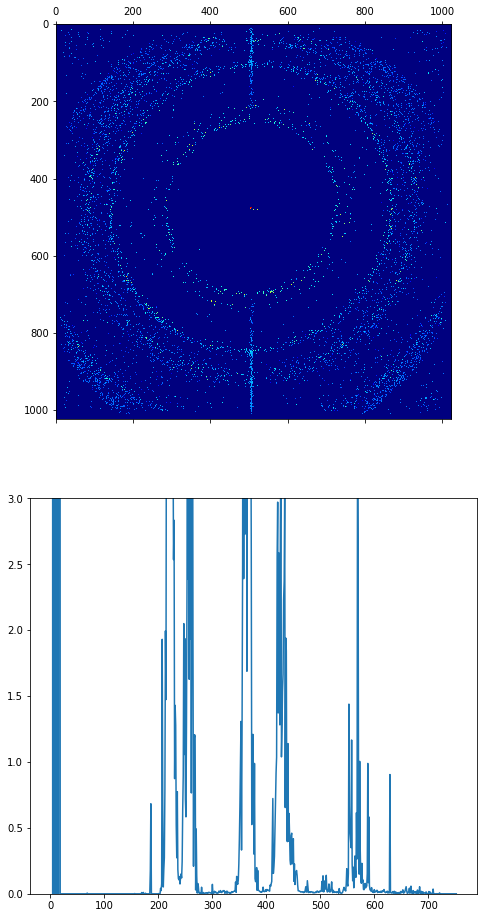

In [4]:
# Show braggvectormap, calculate radial integral

ymax=3
power=0.1

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

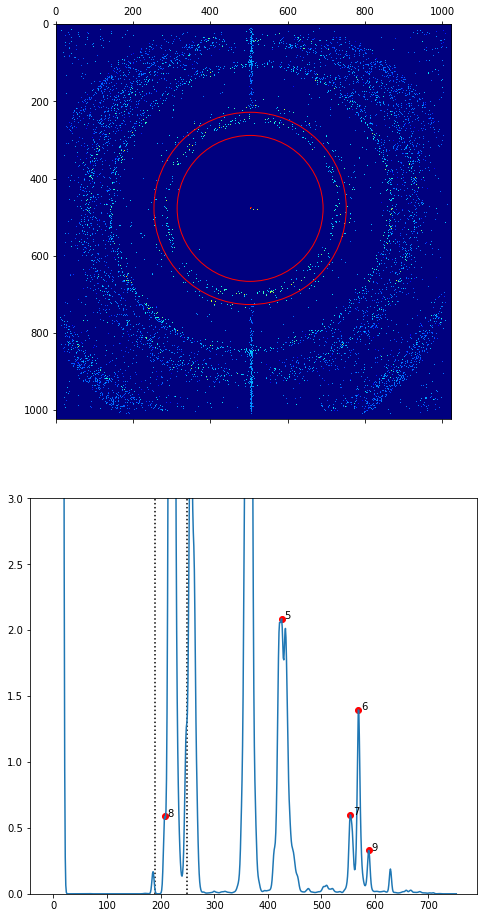

In [5]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 60

# Display params
ymax=3
text_offset = 5
power = 0.1
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

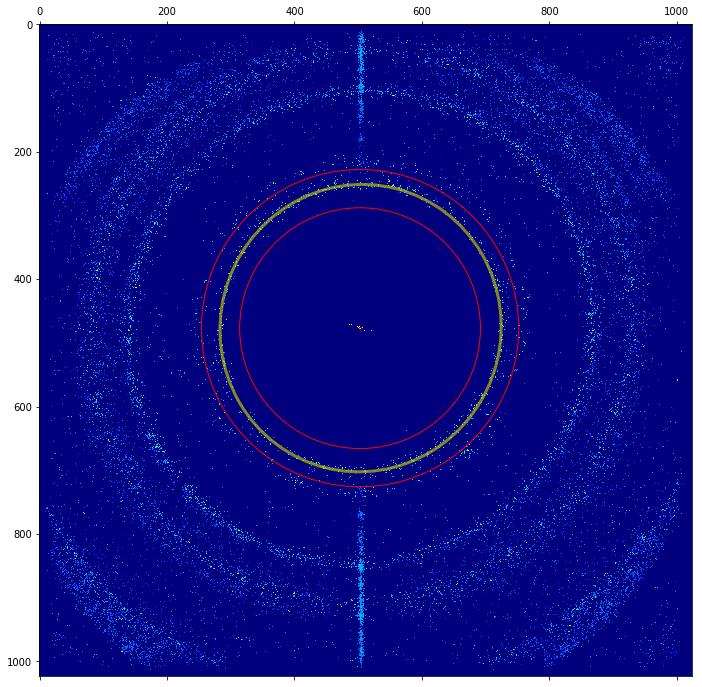

Measured elliptical distortion of 2.49%


In [6]:
# Measure elliptical distortion

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Measure with a mask
# mask = np.ones_like(braggvectormap,dtype=bool)
# mask[:,int(y0-10):int(y0+10)] = False
# ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer, mask)
# x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a,b)/min(a,b) - 1)))

### Correct distortions

In [7]:
braggpeaks_corrected = correct_elliptical_distortion(braggpeaks, ellipse_params)

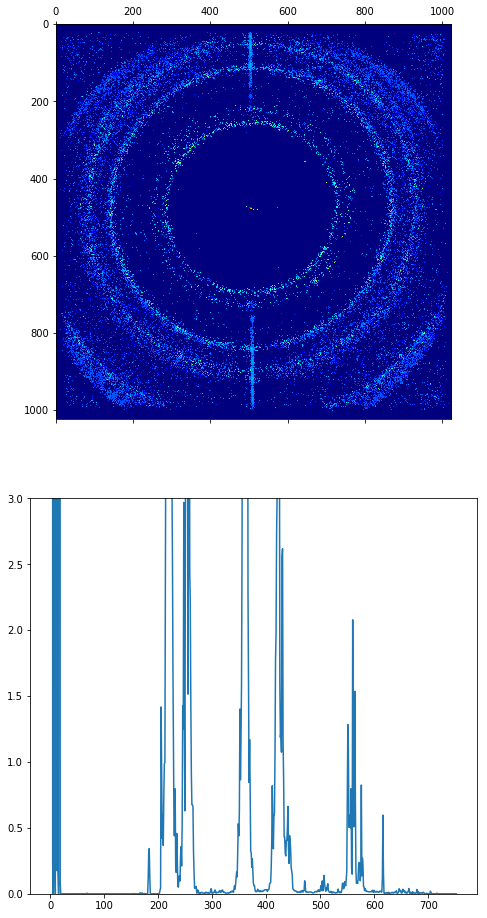

In [8]:
# Get new Bragg vector map and radial integral

ymax=3
power=0.1

braggvectormap_corrected = get_bragg_vector_map(braggpeaks_corrected,Q_Nx,Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_corrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_corrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_corrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

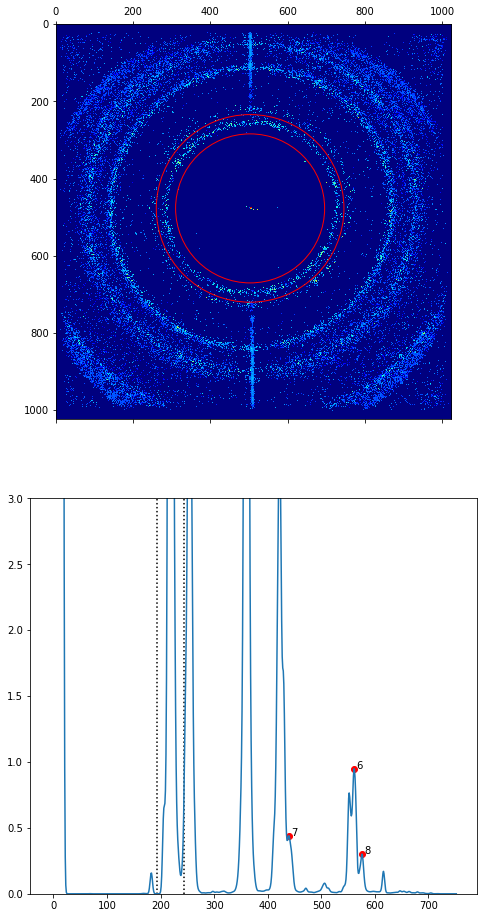

In [9]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 2
annulus_width = 50

# Display params
ymax=3
text_offset = 5
power = 0.1
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_corrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

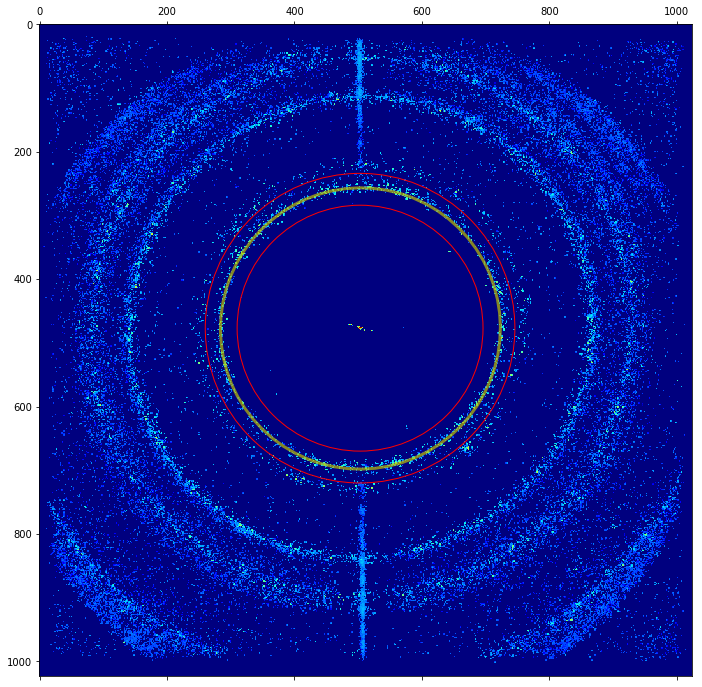

Measured elliptical distortion of 0.625%


In [10]:
# Measure elliptical distortion

ellipse_params_corrected,_ = measure_elliptical_distortion(braggvectormap_corrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params_corrected

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_corrected**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a,b)/min(a,b) - 1)))

### Relevant Mathematics

The discussion below includes the formalism for:

- the elliptical fitting routine
- conversion between the two representations of ellipses used here
- derivation of the transformation used to correct the measured elliptical distortions

#### Fitting ellipses

The representation of an ellipse we'll use for fitting purposes is

\begin{equation}
A(x-x_0)^2 + B(x-x_0)(y-y_0) + C(y-y0)^2 = 1
\end{equation}

The coordinates are $x$, $y$, and we will fit the five parameters $p = (x_0, y_0, A, B, C)$.  For some datapoint with intensity $I$ at $x_d$, $y_d$, we associate an error with respect to parameters $p$ given by $E(x_d,y_d,I; p) = I\cdot(A(x_d-x_0)^2 + B(x_d-x_0)(y_d-y_0) + C(y_d-y0)^2 - 1)$.  We find the best fit ellipse by finding

\begin{equation}
\underset{p}{\mathrm{argmin}} \sum_i E(x_i,y_i,I_i; p)^2
\end{equation}

where the sum runs over all datapoints $(x_i,y_i,I_i)$.

#### Converting representations

The parameters $x_0, y_0$ are the ellipse center; the parameters $A, B, C$ are related to the semiaxes and rotation.  Here, we briefly show that we can extract the semiaxes $a,b$ and rotation $\theta$ via:

\begin{equation}
\begin{matrix}
a^2    &=& \frac{2}{A+(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
b^2    &=& \frac{2}{A-(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
\theta &=& \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)
\end{matrix}
\end{equation}

To derive these conversions, we begin from the representation of an ellipse

\begin{equation}
\frac{x'^2}{a^2} + \frac{y'^2}{b^2} = 1
\end{equation}

where $a$ and $b$ are the semiaxes, oriented along the $x'$ and $y'$ axes, respectively.  Now let $(x',y')$ be rotated counterclockwise by $\theta$ with respect to a coordinate system $(x,y)$.  Then

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta   &  \sin\theta  \\
-\sin\theta  &  \cos\theta
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}

and the ellipse is

\begin{equation}
\frac{(x\cos\theta + y\sin\theta)^2}{a^2} + \frac{(-y\sin\theta + x\cos\theta)^2}{b^2} = 1
\end{equation}

which is equivalent to the ellipse from the prior section, where

\begin{equation}
\begin{matrix}
A &=& \frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}        \\
B &=& 2\sin\theta\cos\theta\left(\frac{-a^2+b^2}{a^2b^2}\right)  \\
C &=& \frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}
\end{matrix}
\end{equation}

The task at hand is to solve these three equations for $a, b, \theta$.

From the second equation, using $2\sin\theta\cos\theta = \sin2\theta$ we find $\frac{B}{\sin2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Subtracting the first and third equations and using $\cos^2\theta - \sin^2\theta = \cos2\theta$, we find $\frac{A-C}{\cos2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Setting these two results equal to one another, we find $\theta = \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)$.

Adding the first and third equations gives $A+C=\frac{1}{a^2}+\frac{1}{b^2}$, and combining this with $\frac{B}{\sin2\theta}  =\frac{1}{a^2} - \frac{1}{b^2}$ by adding and subtracting gives, respectively:

\begin{equation}
a^2 = \frac{2}{A+\frac{B}{\sin2\theta}+C}        \\
b^2 = \frac{2}{A-\frac{B}{\sin2\theta}+C} 
\end{equation}

Recalling that $\sin(\tan^{-1}(\alpha)) = \frac{\alpha}{\sqrt{1+\alpha^2}}$, we substitute our expression for $\theta$ into $\sin2\theta$ and find $\frac{B}{\sin2\theta} = (A-C)\left(1+(\frac{B}{A-C})^2\right)^\frac{1}{2}$.  Substituting into the expressions above for $a^2$ and $b^2$ completes the derivation.

#### Transforming ellipses to circles

To correct any measured elliptical distortion, we apply an affine linear transformation of the form

\begin{equation}
T = 
\begin{pmatrix}
T_{11}   &   T_{12}   \\
T_{21}   &   T_{22}
\end{pmatrix}
\end{equation}

Geometrically, if we think of the ellipse as the conic section resulting from a plane intersecting a cone, we want a transformation which tilts the plane until it is perpendicular with the cone's axis.  Here, we use the transformation which compresses the ellipse the major axis until it is the same size as the minor axis.

For ellipse parameters $a$, $b$, $\theta$, assume without loss of generality that $a>b$.  We want a transformation which compresses by a factor of $s = \frac{b}{a}$.  If $\theta = 0$, then

\begin{equation}
T_0 = 
\begin{pmatrix}
s   &   0   \\
0   &   1
\end{pmatrix}
\end{equation}

For finite $\theta$, we simply rotate this transformation matrix, using the usual rotation matrix $R$:

\begin{align}
T &= R^{-1}T_0R \\
  &=
\begin{pmatrix}
    \cos\theta   &   -\sin\theta   \\
    \sin\theta   &   \cos\theta
\end{pmatrix}
\begin{pmatrix}
    s   &   0   \\
    0   &   1
\end{pmatrix}
\begin{pmatrix}
     \cos\theta   &   \sin\theta   \\
    -\sin\theta   &   \cos\theta
\end{pmatrix}  \\
 &=
\begin{pmatrix}
    \sin^2\theta + s\cdot\cos^2\theta     &    \sin\theta\cos\theta(s-1)          \\
    \sin\theta\cos\theta(s-1)             &    s\cdot\sin^2\theta + \cos^2\theta
\end{pmatrix}
\end{align}

For an original datapoint $(x,y)$, if we neglect translation of the center of coordinates here for simplicity, the  corresponding elliptical distortion corrected datapoint $(x',y')$ will be

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
T
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}